# Implementing a high-resolution bayesian normative model for cortical thickness using a CSS spectral kernel and PYMC with ADVI

---

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v4.2.2


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = os.path.abspath('../../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

### Brain visualization functions

---

In [5]:
from nilearn import datasets, surface, plotting
from matplotlib.colors import LinearSegmentedColormap


In [6]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{main_dir}/data/templates/ones.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
lrx = np.concatenate([lx - expand, rx + expand])
lry = np.concatenate([ly, ry])
lrz = np.concatenate([lz, rz])
lrt = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
lrxyz = np.array([lrx, lry, lrz]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


In [7]:
# arbitrary colormap
mycm = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.1, 0.1, 1.,)),
        # (0.4999, (0.9, 0.9, 1.,)),
        (0.25, (0.1, 1., 1.,)),
        # (0.4999, (0.9, 1., 1.,)),
        (0.5, (1., 1., 1.,)),
        # (0.5001, (1., 1., 0.9,)),
        (0.75, (1., 1., 0.1,)),
        # (0.5001, (1., 0.9, 0.9,)),
        (1.0, (1., 0.1, 0.1,)),
    )
)

mycm_dark = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.05, 1., 1.,)),
        (0.35, (0.05, 0.05, 1.,)),
        (0.5, (0.2, 0.05, 0.05,)),
        (0.65, (1., 0.05, 0.05,)),
        (1.0, (1., 1., 0.05,)),
    )
)

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

# load sulcal depth for background
sulcal_depth = nib.load(f"{main_dir}/data/templates/hcp_surf/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii")


# visualization via nilearn
def plot_data_on_brain_surface(data, title="", cmap=mycm, symmetric_cbar=True, vmax=None, vmin=None, background_data=sulcal_depth.get_fdata()[0], darkness=0.1, auto_vlim_quantile=0.05, colorbar_format=None):
    """
    Plot a cifti-like data over the fs-LR32k surface space.
    ----------------------------------------------------------------
    Parameters:
        - data: a vector of shape (59412,) to be visualized.
        - title: the title of generated plot.
        - cmap: the colormap used for the plot.
        - symmetric_cbar: bool, Specifies whether the 
          colorbar should be symmetric (centered at zero).
        - vmax: colorbar max limit.
        - vmin: colorbar min limit.
        - background data: a surface data to project as a shadow
          behind the main data. (use None for no background)
        - darkness: the background effect
        - auto_vlim_quantile: the quantile to define vmin and vmax
          automatically (should be in the range of [0,0.5)]).
        - colorbar_format: string format for numbers in colorbar.
    ----------------------------------------------------------------
    """
    # Initialization
    if vmax is None:
        vmax = np.quantile(data,1 - auto_vlim_quantile)
    if vmin is None:
        vmin = np.quantile(data,auto_vlim_quantile)
    if symmetric_cbar:
        (vmin, vmax) = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
    if background_data is not None:
        background = True
    else:
        background = False
    
    # surface center
    cxyz=(lrxyz.min(0) + lrxyz.max(0))/2

    # transfer data to surface scalar
    surface_scalars = np.empty(lrx.shape[0])
    surface_scalars[:] = np.nan
    surface_scalars[surface_mask] = data.copy()

    # decompose left and right information
    left_surface_scalars = surface_scalars[:lx.shape[0]]
    right_surface_scalars = surface_scalars[-rx.shape[0]:]
    
    # Generate background data
    surface_background_data = np.zeros(lrx.shape[0])
    surface_background_data[surface_mask] = background_data.copy()
    left_background_data = surface_background_data[:lx.shape[0]]
    right_background_data = surface_background_data[-rx.shape[0]:]


    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

    zoom_coeff = 0.85

    # 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[0,0],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
    axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
    axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[0,1],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
    axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
    axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[1,0],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
    axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
    axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[1,1],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
    axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
    axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

    fig.suptitle(title, fontsize=24, y=0.98);
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(
        axes[0,0],
        width="30%",
        height="4%",
        loc="center",
        bbox_to_anchor=(-0., 0.02, 1., 1.),
        bbox_transform=fig.transFigure,
        borderpad=0,
    )
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap
        ),
        cax=axins,
        aspect=10,
        orientation='horizontal',
        format=colorbar_format,
    )
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(length=0)


## Load aggregated data

---

In [8]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0).reset_index(drop=True)
demography_df.head()


age  thickness  sex     subject_ID dataset           site  siteCode
0  32.0   2.636395  1.0  HCP-YA-130518  HCP-YA  HCP-YA-site_0         0
1  35.0   2.633850  1.0  HCP-YA-192237  HCP-YA  HCP-YA-site_0         0
2  31.0   2.704905  1.0  HCP-YA-859671  HCP-YA  HCP-YA-site_0         0
3  33.0   2.629196  0.0  HCP-YA-158136  HCP-YA  HCP-YA-site_0         0
4  22.0   2.760889  0.0  HCP-YA-192136  HCP-YA  HCP-YA-site_0         0

## Load high-resolution thickness data

---

In [9]:
all_thickness_data = load_np(f'{main_dir}/data/npy/thickness_all_datasets.npy');


## Load the CSS kernel

---

In [10]:
# load the stored kernel
fwhm = 5
css_kernel_eigenvalues = load_np(f'{main_dir}/data/npy/css_kernel_eigenvalues_{fwhm}mmFWHM.npy');
css_kernel_eigenvectors = load_np(f'{main_dir}/data/npy/css_kernel_eigenvectors_{fwhm}mmFWHM.npy');


## Encode the high-resolution data by kernel and attach to the demography data

---

In [11]:
# center the data prior to encoding
all_thickness_data_encoded = np.dot(all_thickness_data, css_kernel_eigenvectors)
all_thickness_data_encoded.shape


(2473, 2001)

In [12]:
demography_extended_df = pd.concat(
    [
        demography_df,
        pd.DataFrame(
            all_thickness_data_encoded,
            columns=[f'thickness_css_{i}' for i in range(all_thickness_data_encoded.shape[1])],
        ),
    ],
    axis=1,
)

demography_extended_df.head()


age  thickness  sex     subject_ID dataset           site  siteCode  \
0  32.0   2.636395  1.0  HCP-YA-130518  HCP-YA  HCP-YA-site_0         0   
1  35.0   2.633850  1.0  HCP-YA-192237  HCP-YA  HCP-YA-site_0         0   
2  31.0   2.704905  1.0  HCP-YA-859671  HCP-YA  HCP-YA-site_0         0   
3  33.0   2.629196  0.0  HCP-YA-158136  HCP-YA  HCP-YA-site_0         0   
4  22.0   2.760889  0.0  HCP-YA-192136  HCP-YA  HCP-YA-site_0         0   

   thickness_css_0  thickness_css_1  thickness_css_2  ...  thickness_css_1991  \
0       540.848068       328.405088       -58.875203  ...           -2.989428   
1       543.507714       323.441478       -50.223979  ...           -2.861579   
2       557.540900       334.750308       -47.242142  ...           -1.953069   
3       541.266533       324.140321       -55.719439  ...           -0.562489   
4       568.037553       342.473082       -61.126235  ...           -0.157777   

   thickness_css_1992  thickness_css_1993  thickness_css_1994  \
0           -0.068005            3.195871           -0.486385   
1            0.173527            0.470815            0.335621   
2            1.547393            1.052983           -0.282225   
3            0.933322            0.347921            1.346396   
4            1.118155            0.281123           -0.601192   

   thickness_css_1995  thickness_css_1996  thickness_css_1997  \
0            1.388692            0.790643           -1.385377   
1            1.752842           -1.659001           -0.929015   
2           -0.662044           -0.657760           -1.773588   
3           -1.391554           -0.904728           -0.204043   
4            0.991797           -0.982564           -0.976174   

   thickness_css_1998  thickness_css_1999  thickness_css_2000  
0           -0.132055            0.294909            1.125785  
1           -1.196669            0.499736           -0.200770  
2           -1.853987           -0.479072           -1.234758  
3            0.522450           -0.127720            1.778896  
4            1.511172           -0.405743            0.693013  

[5 rows x 2008 columns]

## Visualize encoded thickness data

---

CPU times: user 280 ms, sys: 101 ms, total: 381 ms
Wall time: 166 ms


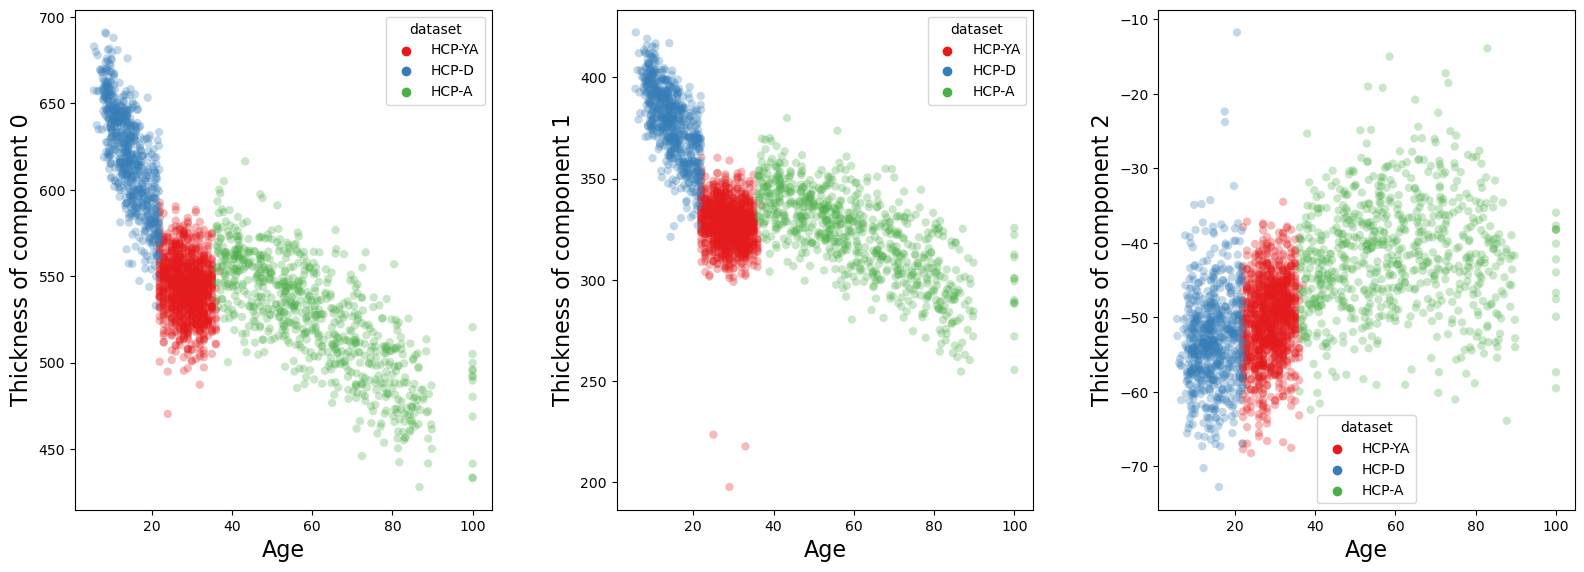

In [45]:
%%time

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=f'thickness_css_{c}',
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


CPU times: user 306 ms, sys: 115 ms, total: 420 ms
Wall time: 184 ms


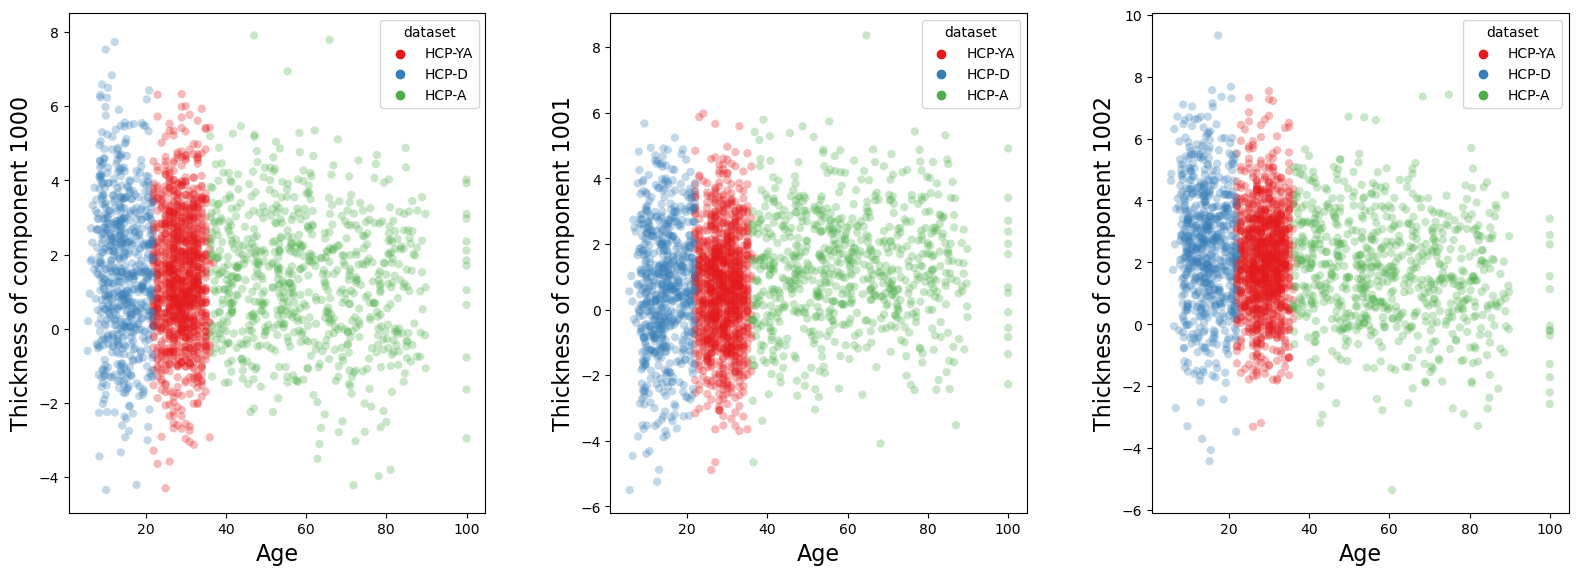

In [117]:
%%time

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=f'thickness_css_{c+1000}',
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c+1000}', fontsize=16)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


## Run parallel models to fit normative distributions for every kernel

---

In [104]:
def run_pymc_advi_on_kernel(kernel_name):
    # sample from required columns
    sample_df = demography_extended_df[['age', 'site', 'sex', kernel_name]].copy()

    # Data preperation
    age = sample_df['age'].values
    age_standardized = (age - age.mean()) / age.std()
    thickness = sample_df[kernel_name].values
    thickness_standardized = (thickness - thickness.mean()) / thickness.std()
    site_idxs, sites = pd.factorize(sample_df['site'])
    sex_idxs, sexes = pd.factorize(sample_df['sex'])
   
    # Splines to model nonlinear age effects on thickness
    # number of spline nuts (could be tuned)
    num_knots = 3
    knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
    # create b spline basis for regression using patsy
    B_spline_age = patsy.dmatrix(
        "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
        {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
    )

    coords = {
        "site": sites,
        "sex": sexes,
        "splines": np.arange(B_spline_age.shape[1]),
        "obs_id": np.arange(len(site_idxs)),
    }

    kernel_advi_model = pm.Model(coords=coords, aesara_config={'compute_test_value': 'off'})
    # models_dict[kernel_name] = advi_model

    # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
    with kernel_advi_model:
        # minibatch variables
        age_standardized_t = pm.Minibatch(age_standardized, 512,)
        sex_idx_t = pm.Minibatch(sex_idxs, 512)
        site_idx_t = pm.Minibatch(site_idxs, 512)
        B_spline_age_t = pm.Minibatch(B_spline_age, 512)
        thickness_standardized_t = pm.Minibatch(thickness_standardized, 512)

        # Hyperpriors for site groups (as if we have random group effects)
        mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
        sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
        sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)

        # Priors    
        # sex effects (similar to fixed sex effects (intercept only))
        intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")

        # site effects (similar to random site effects (intercept only))
        #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
        intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
        intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")

        # age splines
        w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")

        # Estimated thickness
        thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))

        # Model error
        # nonlinear age error
        w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")

        # constant sex error
        error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")

        # random site error
        error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
        error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")

        # Error estimate
        thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))

        # Skewness estimate
        # thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
        # for sake of simplicity let's not model skewness

        # Likelihood (sampling distribution) of observations
        # need to figure out how to bound the distribution
        # pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
        # thickness_like = pm.SkewNormal(
        thickness_like = pm.Normal(
            "thickness_like",
            mu=thickness_est,
            sigma=thickness_error,
            observed=thickness_standardized_t,
            total_size=len(sample_df),
        )
            # alpha=thickness_skewness,
    
        # run ADVI with minibatch
        kernel_approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

        # sample from trace
        kernel_advi_model_idata = pm.sample_prior_predictive()
        kernel_advi_model_idata.extend(kernel_approx.sample(2000))
        pm.sample_posterior_predictive(kernel_advi_model_idata, extend_inferencedata=True)
        # idata_dict[kernel_name] = advi_model_idata
    
    stored_model_file = f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc'
    kernel_advi_model_idata.to_netcdf(ensure_dir(stored_model_file))
    return (kernel_name, stored_model_file)
    

In [ ]:
%%capture multiprocessing_log

import multiprocessing
import time

def mute():
    sys.stdout = open(os.devnull, 'w')

PROCESSES = 16
with multiprocessing.Pool(PROCESSES, initializer=mute) as pool:
    collected_results = pool.map(
        run_pymc_advi_on_kernel,
        [f'thickness_css_{i}' for i in range(all_thickness_data_encoded.shape[1])]
    )


## Visualize validity of models over the kernel

---

In [22]:
# sample from required columns
sample_df = demography_extended_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])

# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
num_knots = 3
knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.dmatrix(
    "bs(age_standardized, knots=knots, degree=3, include_intercept=True) - 1",
    {"age_standardized": age_standardized, "knots": knot_list[1:-1]},
)

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}

CPU times: user 9.79 s, sys: 8.6 s, total: 18.4 s
Wall time: 1.84 s


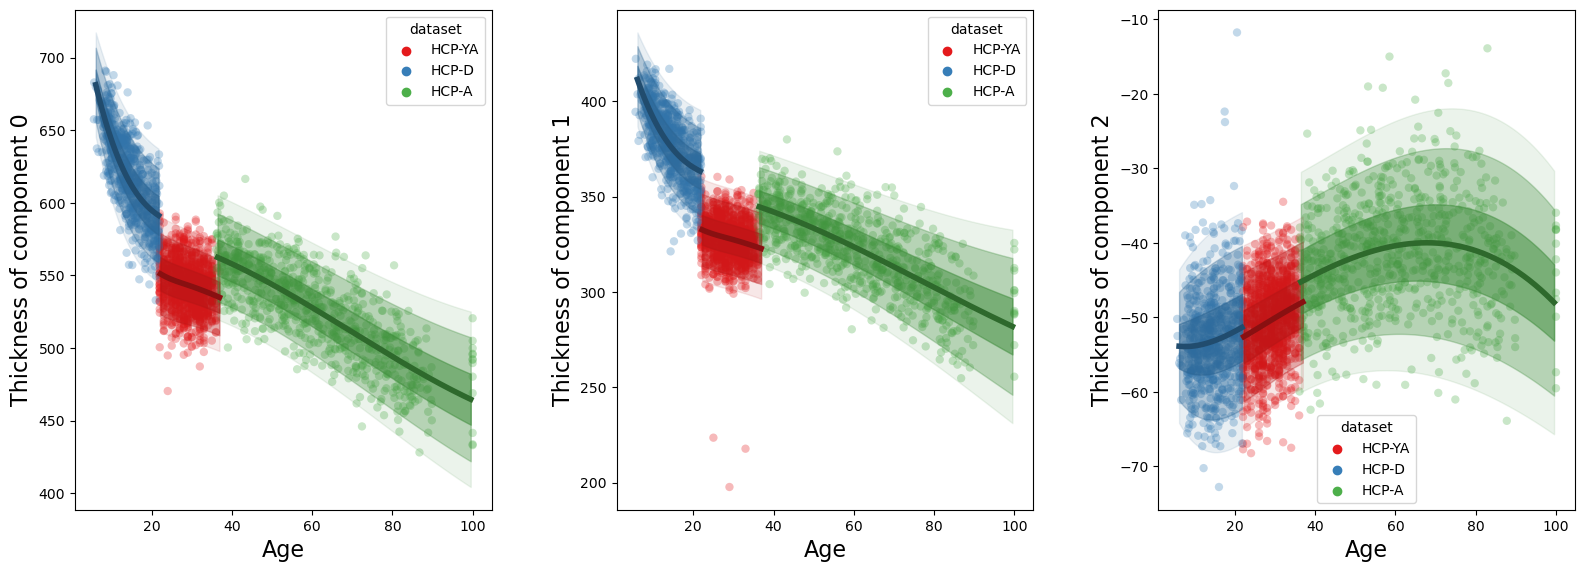

In [23]:
%%time

# sample from required columns
sample_df = demography_extended_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_css_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        prediction_B_spline_age = patsy.dmatrix(
            "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
            {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        )

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


CPU times: user 10.6 s, sys: 10 s, total: 20.7 s
Wall time: 1.67 s


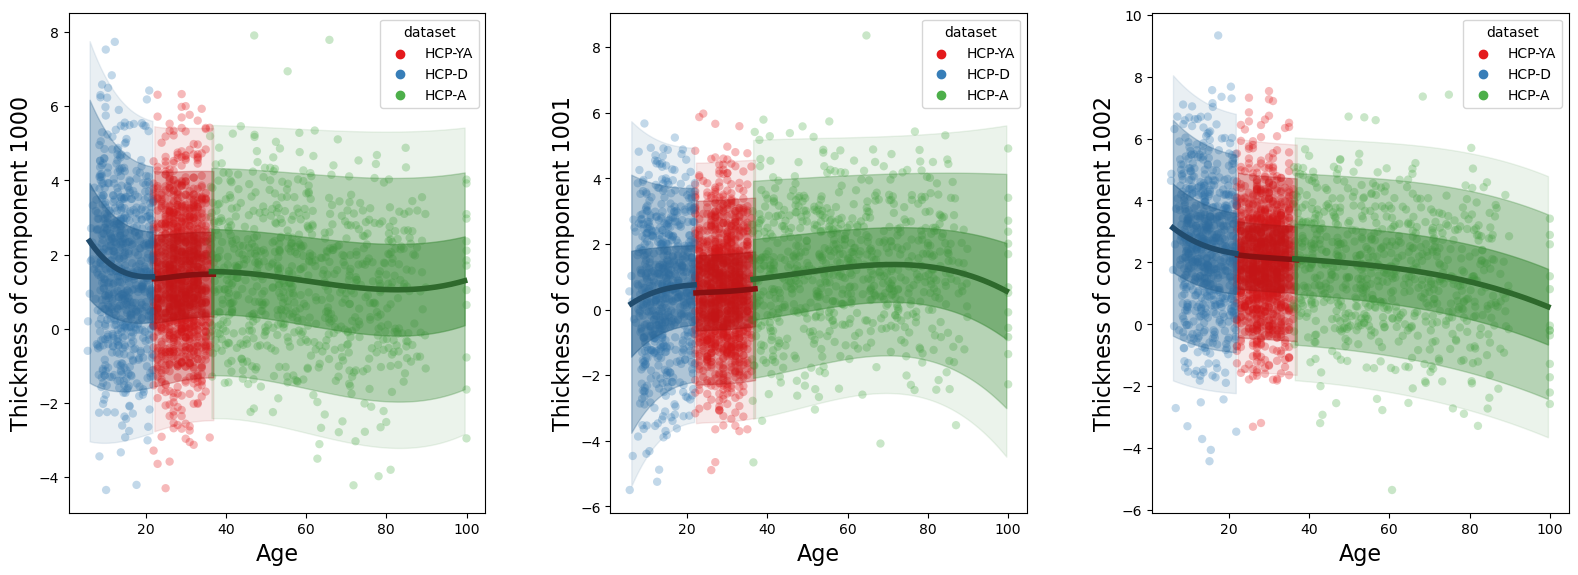

In [120]:
%%time

# sample from required columns
sample_df = demography_extended_df

# Data preperation
age = sample_df['age'].values
age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(sample_df['site'])
sex_idxs, sexes = pd.factorize(sample_df['sex'])


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_css_{c + 1000}'
    thickness = sample_df[kernel_name].values
    thickness_mean = thickness.mean()
    thickness_std = thickness.std()
    thickness_standardized = (thickness - thickness_mean) / thickness_std
    
    sns.scatterplot(
        data=demography_extended_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        hue='dataset',
        palette="Set1",
        alpha = 0.3,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c + 1000}', fontsize=16)

    for idx in np.unique(site_idxs):
        xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
        selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
        # post = advi_model_idata.posterior
        advi_model_idata = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc')
        post = advi_model_idata.posterior

        prediction_B_spline_age = patsy.dmatrix(
            "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
            {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
        )

        y_ppc_mu = (
            post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
            post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_mu_mean = y_ppc_mu.mean(1)

        y_ppc_sigma = (
            post['error_sex'].stack(sample=("chain", "draw"))[0].data +
            post['error_site'].stack(sample=("chain", "draw"))[idx].data +
            np.dot(
                prediction_B_spline_age,
                post['w_error_age'].stack(sample=("chain", "draw"))
            )
        )
        y_ppc_sigma_mean = y_ppc_sigma.mean(1)

        # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

        # need to ensure the correctness
        quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

        thickness_quantiles = {
            q: (
                (
                    y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                )  * thickness_std +
                thickness_mean
            ) for q in quantiles
        }

        # centile plot
        for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
            ax.fill_between(
                xi[selection],
                thickness_quantiles[q1][selection],
                thickness_quantiles[q2][selection],
                alpha=alpha,
                color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
            )

        ax.plot(
            xi[selection],
            thickness_quantiles[0.5][selection],
            c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
            lw=4,
        )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)


## Generalize the normative model to linear combinations of kernels (arbitrary queries)

---

Let's first test modelling mean thickness with this kernel approach:

The model would include sum of dependent normal distributions. First we need to estimate the covariance structure. Next, we can use it to model mean thickness as a linear combination of normal distributions of the kernels


### Covariance structure

---

In [20]:
# Estimate covariance matrix
covariances = np.cov(all_thickness_data_encoded.T)
correlations = np.corrcoef(all_thickness_data_encoded.T)
covariances.shape


(2001, 2001)

Text(0.5, 1.0, 'Covariance structure (logarithmic colormap)')

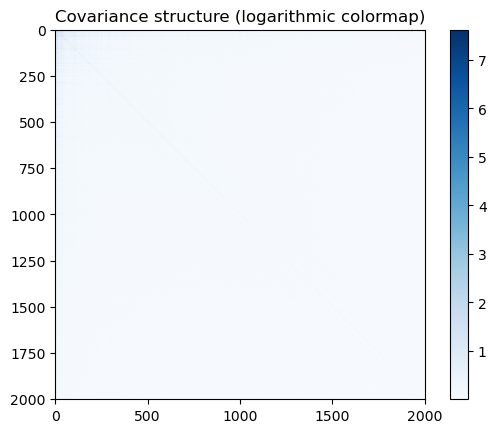

In [136]:
shw = plt.imshow(np.log(1 + np.abs(covariances)), cmap=plt.cm.Blues)
bar = plt.colorbar(shw)
plt.title('Covariance structure (logarithmic colormap)')


Text(0.5, 1.0, 'Absolute correlation')

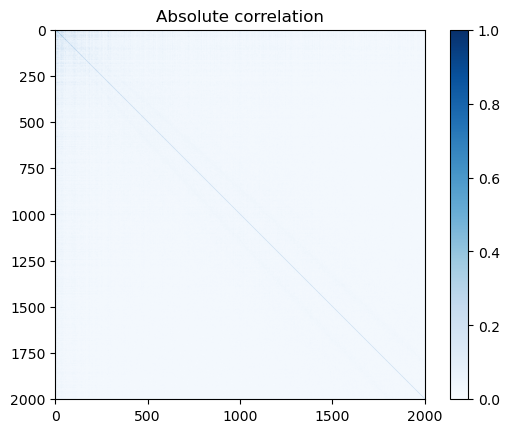

In [137]:
shw = plt.imshow(np.abs(correlations), cmap=plt.cm.Blues, vmin=0, vmax=1)
bar = plt.colorbar(shw)
plt.title('Absolute correlation')


Text(0.5, 1.0, 'Correlation histogram')

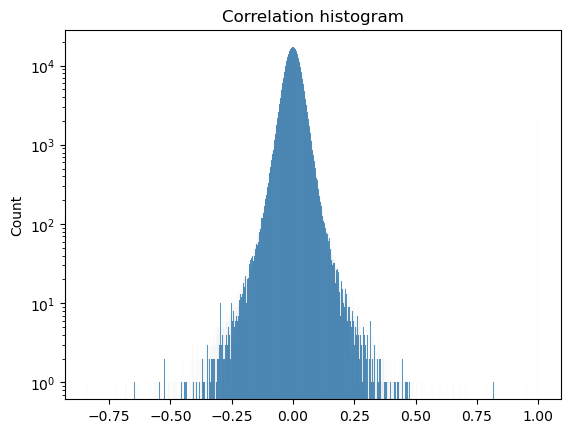

In [140]:
sns.histplot(correlations[np.triu_indices_from(correlations)], log_scale=(False, True))
plt.title('Correlation histogram')


### Linear combination of dependent normal distributions

---

Here, with the assumption that the correlations (dependence structure between kernels) are independent from covariates (age, gender, site, etc.), we model the normal distribution of mean thickness, as a linear combination of normative kernels.

#### Load fitted kernel normative models

---


In [13]:
%%time
# Load all posterior distributions of kernels
kernel_idata = {}

for i in range(all_thickness_data_encoded.shape[1]):
    kernel_name = f'thickness_css_{i}'
    kernel_idata[kernel_name] = az.from_netcdf(f'{main_dir}/data/models/pymc/css_kernel/{kernel_name}_pymc_advi.nc')


CPU times: user 2min 7s, sys: 2.3 s, total: 2min 9s
Wall time: 2min 9s


In [14]:
%%time
# concatenate posteriors along a new dimension
kernel_posteriors = xr.concat([kernel_idata[f'thickness_css_{i}'].posterior for i in range(all_thickness_data_encoded.shape[1])], "kernel")
kernel_posteriors


CPU times: user 8min 51s, sys: 38.6 s, total: 9min 30s
Wall time: 9min 30s


<xarray.Dataset>
Dimensions:                (chain: 1, draw: 2000, kernel: 2001, sex: 2,
                            site: 3, splines: 5, thickness_est_dim_0: 512,
                            thickness_error_dim_0: 512)
Coordinates:
  * chain                  (chain) int64 0
  * draw                   (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
  * sex                    (sex) float64 1.0 0.0
  * site                   (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 0 1 2 3 4
  * thickness_est_dim_0    (thickness_est_dim_0) int64 0 1 2 3 ... 509 510 511
  * thickness_error_dim_0  (thickness_error_dim_0) int64 0 1 2 3 ... 509 510 511
Dimensions without coordinates: kernel
Data variables: (12/13)
    mu_intercept_site      (kernel, chain, draw) float64 0.0008897 ... 0.02339
    intercept_sex          (kernel, chain, draw, sex) float64 0.02289 ... 0.0...
    intercept_site_offset  (kernel, chain, draw, site) float64 -0.5411 ... 0....
    w_age                  (kernel, chain, draw, splines) float64 2.367 ... -...
    sigma_intercept_site   (kernel, chain, draw) float64 0.7149 ... 0.07501
    sigma_error_site       (kernel, chain, draw) float64 0.09844 ... 0.109
    ...                     ...
    error_sex              (kernel, chain, draw, sex) float64 0.1414 ... 0.3931
    error_site_offset      (kernel, chain, draw, site) float64 0.05198 ... 0....
    intercept_site         (kernel, chain, draw, site) float64 -0.3859 ... 0....
    thickness_est          (kernel, chain, draw, thickness_est_dim_0) float64 ...
    error_site             (kernel, chain, draw, site) float64 0.005116 ... 0...
    thickness_error        (kernel, chain, draw, thickness_error_dim_0) float64 ...
Attributes:
    created_at:                 2022-10-26T00:57:06.930264
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [15]:
%%time
kernel_posteriors.to_netcdf(f'{main_dir}/data/models/pymc/combined_css_kernel_posteriors_pymc_advi.nc')


CPU times: user 19min 46s, sys: 24.8 s, total: 20min 11s
Wall time: 20min 11s


In [17]:
%%time
kernel_posterior_means = kernel_posteriors.mean(dim=["chain", "draw"])
kernel_posterior_means


CPU times: user 23.2 s, sys: 28.2 s, total: 51.4 s
Wall time: 51.4 s


<xarray.Dataset>
Dimensions:                (kernel: 2001, sex: 2, site: 3, splines: 5,
                            thickness_est_dim_0: 512, thickness_error_dim_0: 512)
Coordinates:
  * sex                    (sex) float64 1.0 0.0
  * site                   (site) object 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 0 1 2 3 4
  * thickness_est_dim_0    (thickness_est_dim_0) int64 0 1 2 3 ... 509 510 511
  * thickness_error_dim_0  (thickness_error_dim_0) int64 0 1 2 3 ... 509 510 511
Dimensions without coordinates: kernel
Data variables: (12/13)
    mu_intercept_site      (kernel) float64 0.0008734 -0.003786 ... 0.00502
    intercept_sex          (kernel, sex) float64 0.02206 -0.002913 ... 0.03261
    intercept_site_offset  (kernel, site) float64 -0.5472 0.6629 ... 0.3958
    w_age                  (kernel, splines) float64 2.341 0.2836 ... -0.1705
    sigma_intercept_site   (kernel) float64 0.7195 0.8618 ... 0.03515 0.102
    sigma_error_site       (kernel) float64 0.1066 0.1904 ... 0.02533 0.138
    ...                     ...
    error_sex              (kernel, sex) float64 0.1474 0.177 ... 0.4346 0.4106
    error_site_offset      (kernel, site) float64 0.09529 0.6573 ... 0.2045
    intercept_site         (kernel, site) float64 -0.3929 0.4779 ... 0.04568
    thickness_est          (kernel, thickness_est_dim_0) float64 0.02847 ... ...
    error_site             (kernel, site) float64 0.01017 0.07009 ... 0.02825
    thickness_error        (kernel, thickness_error_dim_0) float64 0.413 ... ...

In [18]:
%%time
kernel_posterior_means.to_netcdf(f'{main_dir}/data/models/pymc/combined_css_kernel_posterior_means_pymc_advi.nc')


CPU times: user 51.7 ms, sys: 16.4 ms, total: 68.1 ms
Wall time: 293 ms


#### Modelling mean thickness 🧠

---


In [24]:
# mean thickness vector representation
mean_thickness_vector = np.ones(css_kernel_eigenvectors.shape[0]) / css_kernel_eigenvectors.shape[0]
mean_thickness_vector_encoded = np.dot(mean_thickness_vector.reshape(1,-1), css_kernel_eigenvectors)


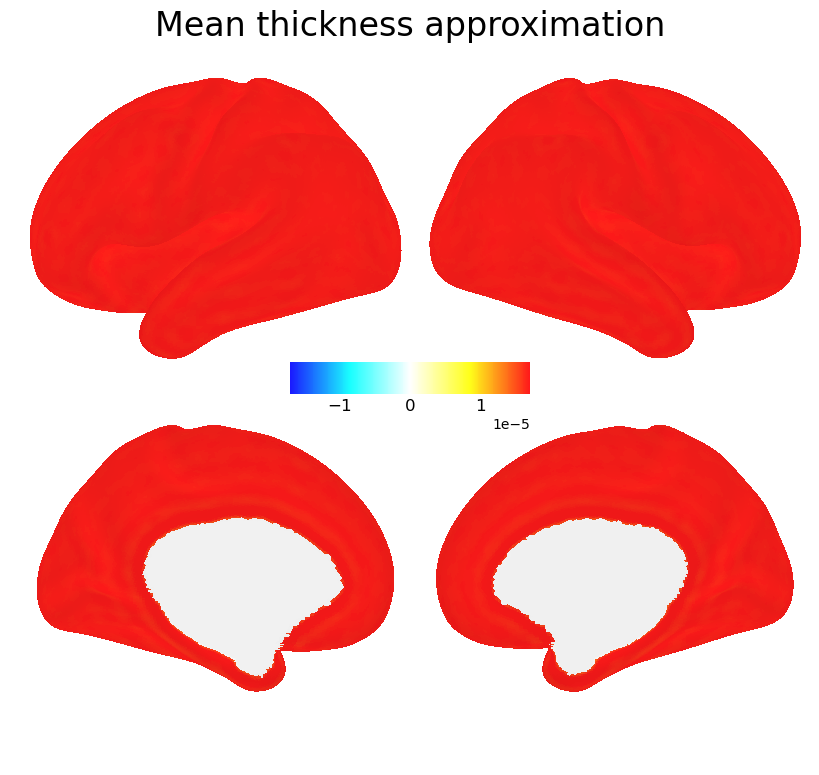

In [145]:
plot_data_on_brain_surface(
    np.dot(mean_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Mean thickness approximation",
    symmetric_cbar=True,
)


CPU times: user 13.3 s, sys: 9.84 s, total: 23.1 s
Wall time: 1.58 s


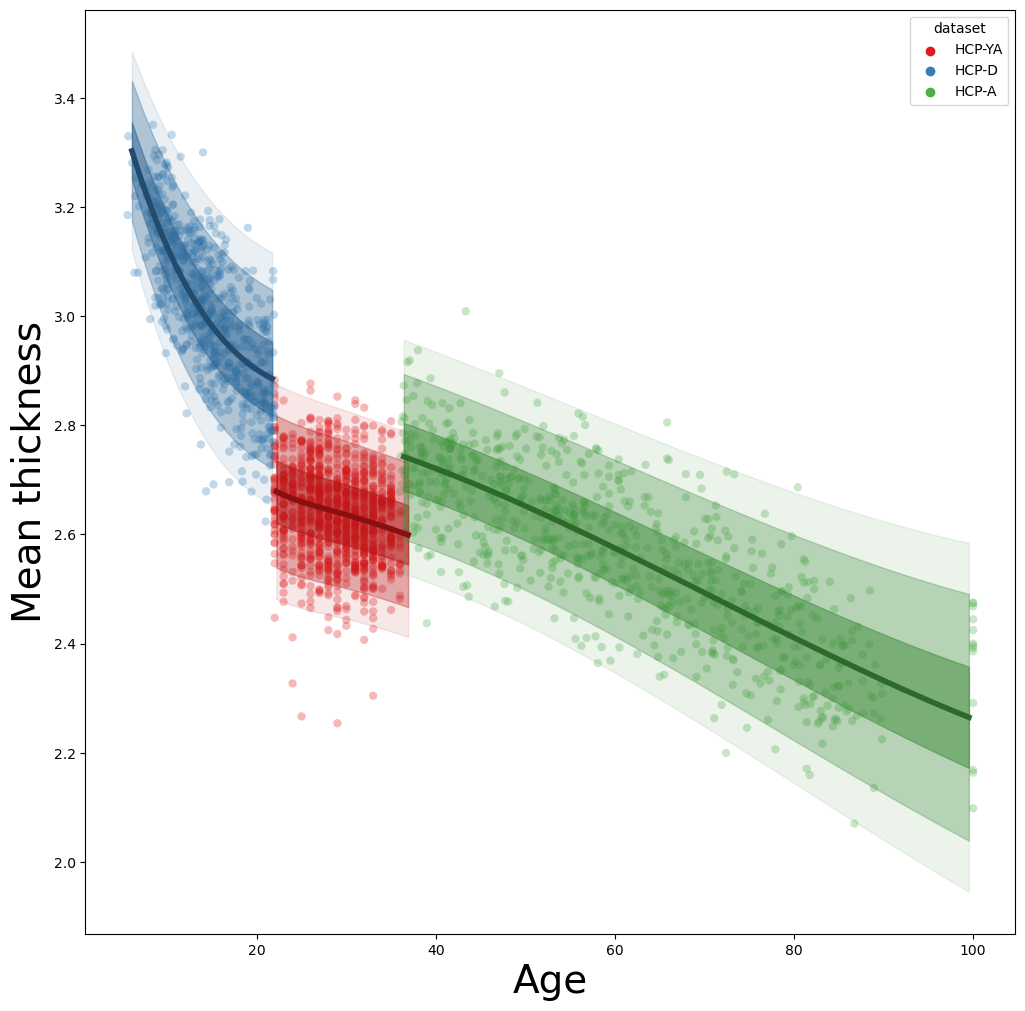

In [89]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# thickness_mean = mean_thickness_vector_encoded.dot(all_thickness_data_encoded.mean(0))
# thickness_std = np.power(
#     np.multiply(
#         mean_thickness_vector_encoded.reshape(-1,),
#         all_thickness_data_encoded.std(0)
#     ).dot(
#         correlations
#     ).dot(
#         np.multiply(
#             mean_thickness_vector_encoded.reshape(-1,),
#             all_thickness_data_encoded.std(0)
#         ),
#     ),
#     0.5
# )

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.array(
        [
            np.power(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ).dot(
                    correlations
                ).dot(
                    np.multiply(
                        mean_thickness_vector_encoded.reshape(-1,),
                        np.array(kernels_y_ppc_sigma_mean).T[i]
                    ),
                ),
                0.5
            ) for i in range(200)
        ]
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


#### Modelling arbitrary queries: thickness of an atlas region 🎯

---


In [90]:
from sklearn.preprocessing import normalize

In [96]:
normalize(mean_thickness_vector.reshape(1,-1), norm='l1')[0]


array([1.68316165e-05, 1.68316165e-05, 1.68316165e-05, ...,
       1.68316165e-05, 1.68316165e-05, 1.68316165e-05])

In [99]:
# load the glasser atlas
atlas_file = f'{main_dir}/data/templates/hcp_parcel/Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii'
atlas = nib.load(atlas_file)


In [140]:
# mean thickness vector representation
region_idx = 8
query_thickness_vector = normalize((atlas.get_fdata()==region_idx).astype(float).reshape(1,-1), norm='l1')[0]
query_thickness_vector_encoded = np.dot(query_thickness_vector.reshape(1,-1), css_kernel_eigenvectors)


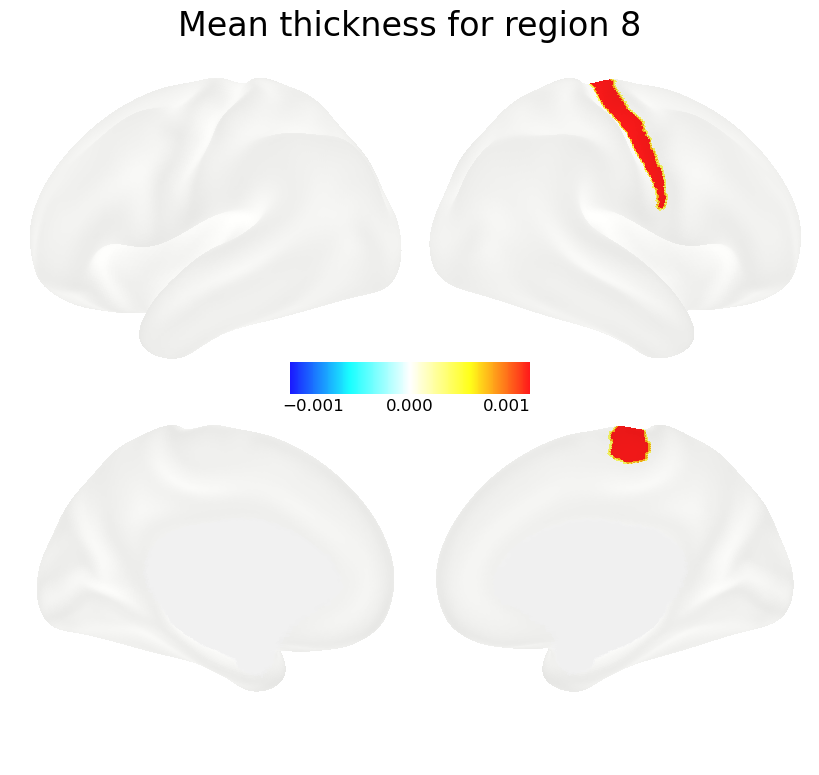

In [141]:
plot_data_on_brain_surface(
    query_thickness_vector,
    # np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Mean thickness for region {region_idx}",
    symmetric_cbar=True, vmin=0, vmax=query_thickness_vector.max()
)


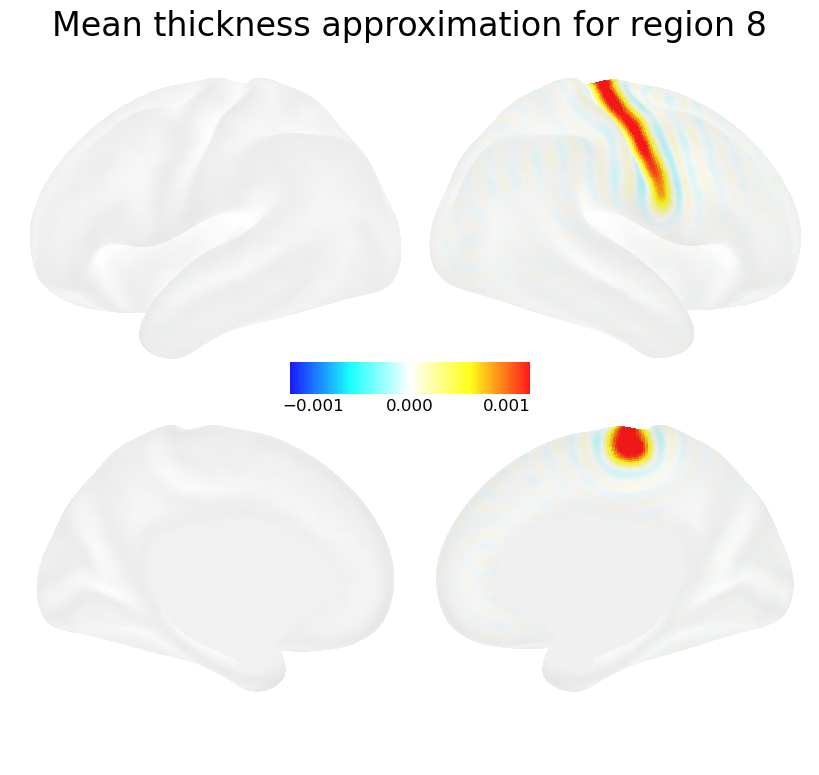

In [142]:
plot_data_on_brain_surface(
    # query_thickness_vector,
    np.dot(query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"Mean thickness approximation for region {region_idx}",
    symmetric_cbar=True, vmin=0, vmax=query_thickness_vector.max()
)


CPU times: user 21 s, sys: 15.5 s, total: 36.5 s
Wall time: 2.38 s


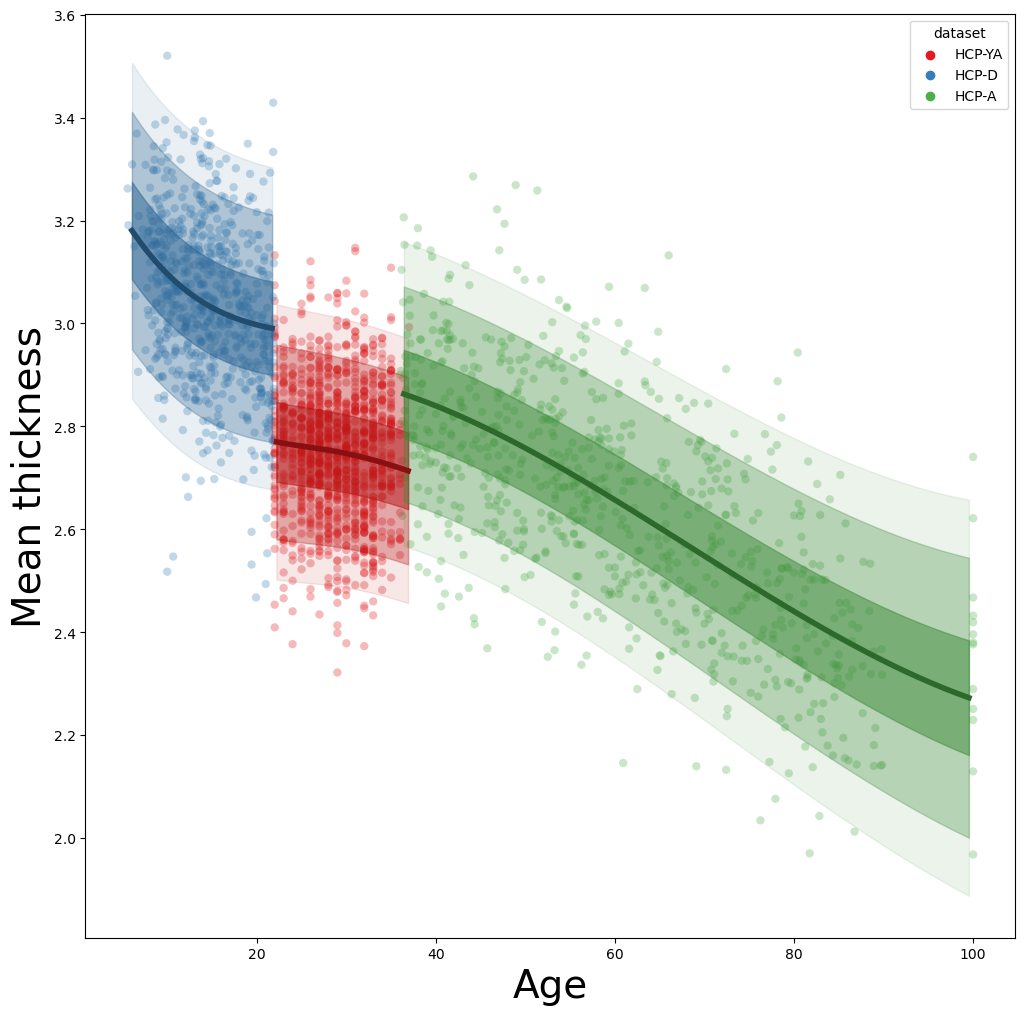

In [143]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

demography_df['query_thickness'] = query_thickness_vector.dot(all_thickness_data.T)

sns.scatterplot(
    data=demography_df,
    x='age',
    y='query_thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(query_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.array(
        [
            np.power(
                np.multiply(
                    query_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ).dot(
                    correlations
                ).dot(
                    np.multiply(
                        query_thickness_vector_encoded.reshape(-1,),
                        np.array(kernels_y_ppc_sigma_mean).T[i]
                    ),
                ),
                0.5
            ) for i in range(200)
        ]
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


#### Modelling arbitrary queries: left vs. right (males) 👈👉

---


In [160]:
# mean thickness vector representation
lr_query_thickness_vector = np.concatenate(
    [
        normalize(np.ones(left_cortical_surface_model.index_count).reshape(1,-1), norm='l1')[0],
        -normalize(np.ones(right_cortical_surface_model.index_count).reshape(1,-1), norm='l1')[0],
    ]
).reshape(-1)
lr_query_thickness_vector_encoded = np.dot(lr_query_thickness_vector.reshape(1,-1), css_kernel_eigenvectors)


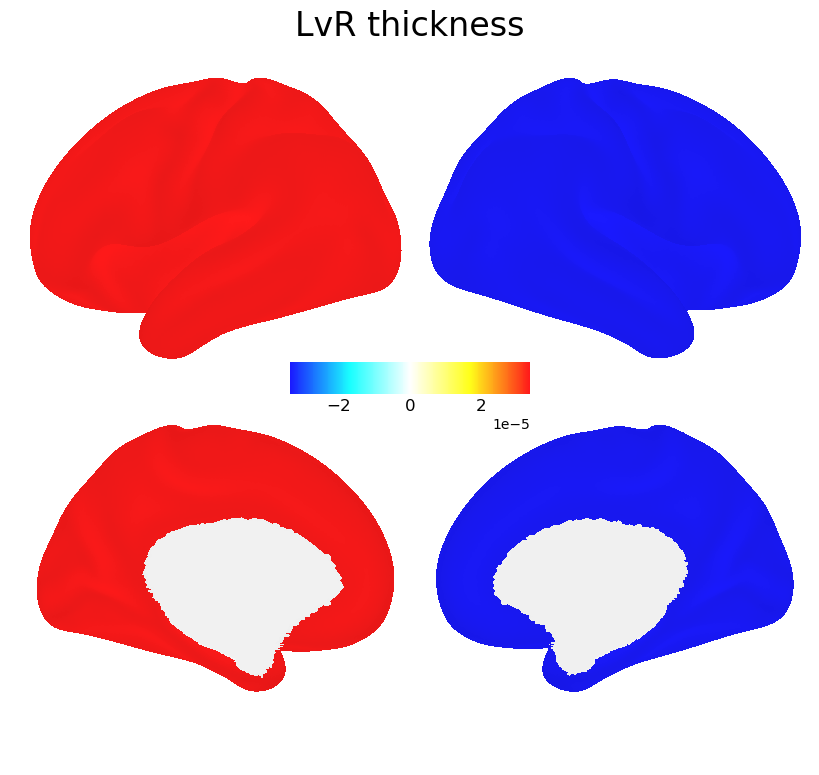

In [161]:
plot_data_on_brain_surface(
    lr_query_thickness_vector,
    # np.dot(lr_query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"LvR thickness",
    symmetric_cbar=True,
)


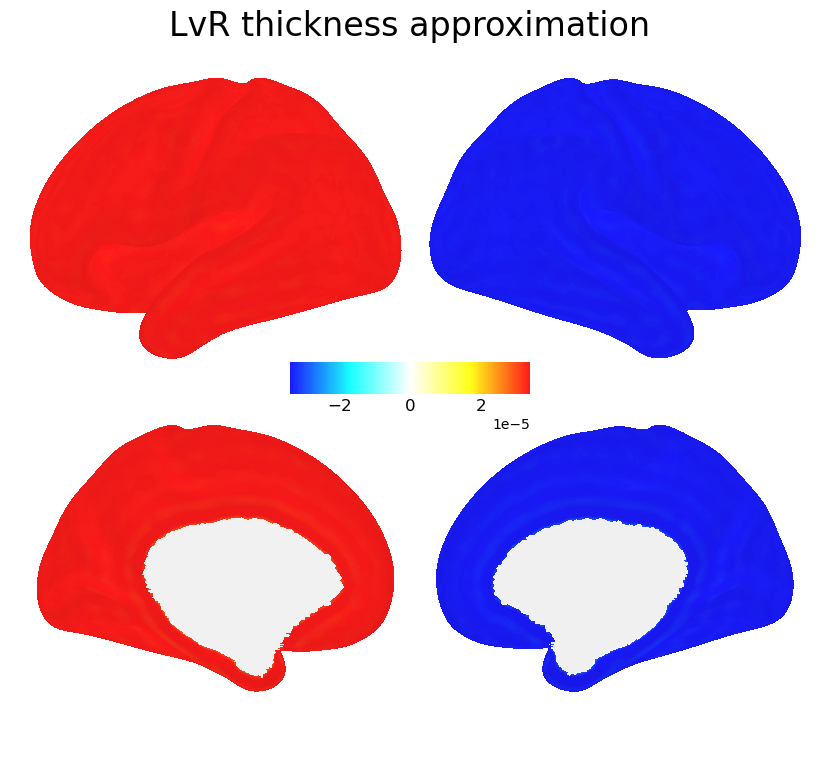

In [162]:
plot_data_on_brain_surface(
    # lr_query_thickness_vector,
    np.dot(lr_query_thickness_vector_encoded, css_kernel_eigenvectors.T)[0],
    title=f"LvR thickness approximation",
    symmetric_cbar=True,
)


In [195]:
all_thickness_data.std()
# all_thickness_data_encoded.std()


0.6247982920722058

CPU times: user 14.3 s, sys: 9.5 s, total: 23.8 s
Wall time: 1.53 s


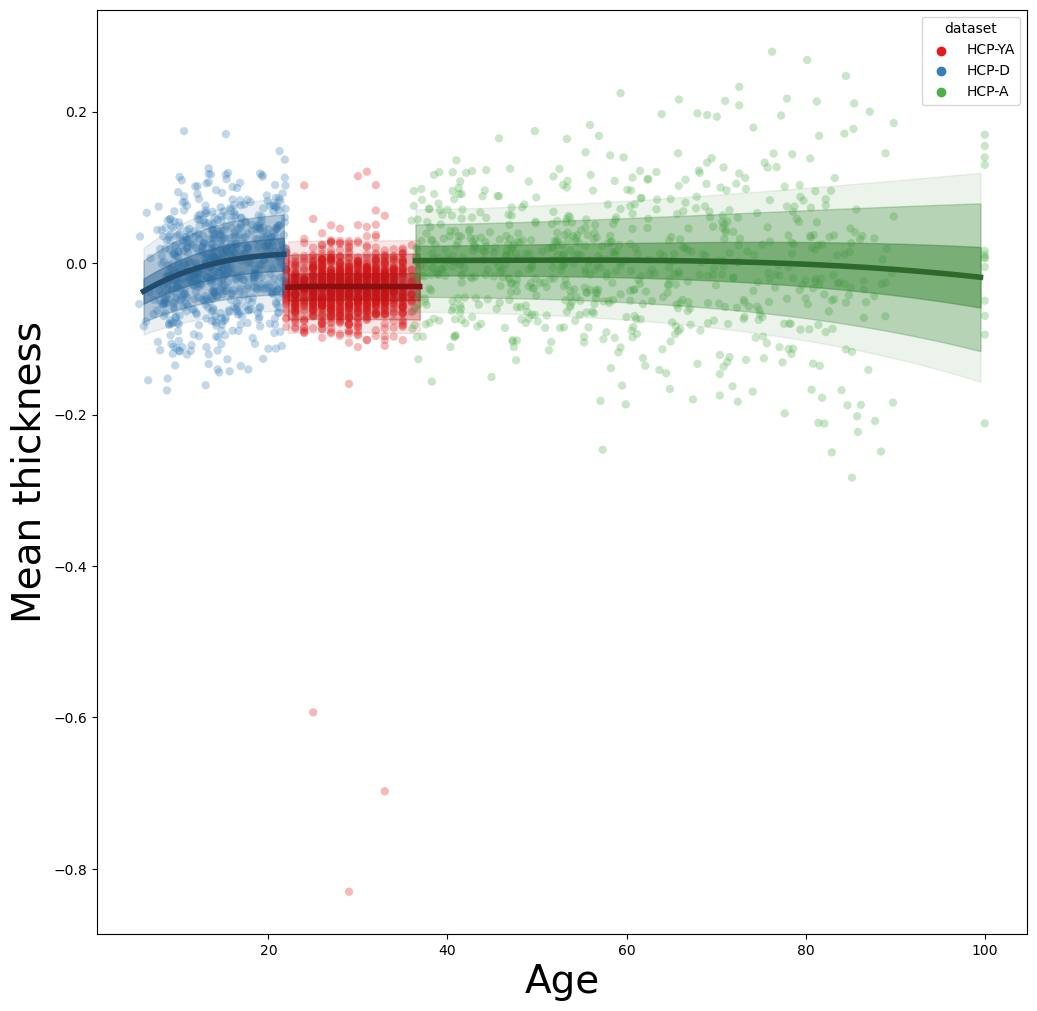

In [196]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

demography_df['query_thickness'] = lr_query_thickness_vector.dot(all_thickness_data.T)

sns.scatterplot(
    data=demography_df,
    x='age',
    y='query_thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(lr_query_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.array(
        [
            np.power(
                np.multiply(
                    lr_query_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ).dot(
                    correlations
                ).dot(
                    np.multiply(
                        lr_query_thickness_vector_encoded.reshape(-1,),
                        np.array(kernels_y_ppc_sigma_mean).T[i]
                    ),
                ),
                0.5
            ) for i in range(200)
        ]
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )


#### Modelling arbitrary queries: high-resolution thickness norm at a given age 📈

---

Question: how would a normally developing brain of a 40 year old man look? 

In [203]:
age_of_interest = 40
sex_of_interest = 0
site_of_interest = 2 # HCP Aging

xi = xr.DataArray([np.min(age), age_of_interest, np.max(age)], dims=["obs_id"])

prediction_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
)[1]

kernels_y_ppc_mu_mean = (
    kernel_posterior_means['intercept_sex'].isel(sex=sex_of_interest) +
    kernel_posterior_means['intercept_site'].isel(site=site_of_interest) +
    xr.dot(
        xr.DataArray(np.asarray(prediction_B_spline_age), dims=["splines"]),
        kernel_posterior_means['w_age']
    )
) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])

high_resolution_mean_thickness_of_interest = np.array(kernels_y_ppc_mu_mean).dot(css_kernel_eigenvectors.T)

kernels_y_ppc_sigma_mean = (
    kernel_posterior_means['error_sex'].isel(sex=sex_of_interest) +
    kernel_posterior_means['error_site'].isel(site=site_of_interest) +
    xr.dot(
        xr.DataArray(np.asarray(prediction_B_spline_age), dims=["splines"]),
        kernel_posterior_means['w_error_age']
    )
) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])


high_resolution_std_thickness_of_interest = np.array(
    [
        np.power(
            np.multiply(
                css_kernel_eigenvectors[i].reshape(-1,),
                np.array(kernels_y_ppc_sigma_mean).T
            ).dot(
                correlations
            ).dot(
                np.multiply(
                    css_kernel_eigenvectors[i].reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T
                ),
            ),
            0.5
        ) for i in range(css_kernel_eigenvectors.shape[0])
    ]
)


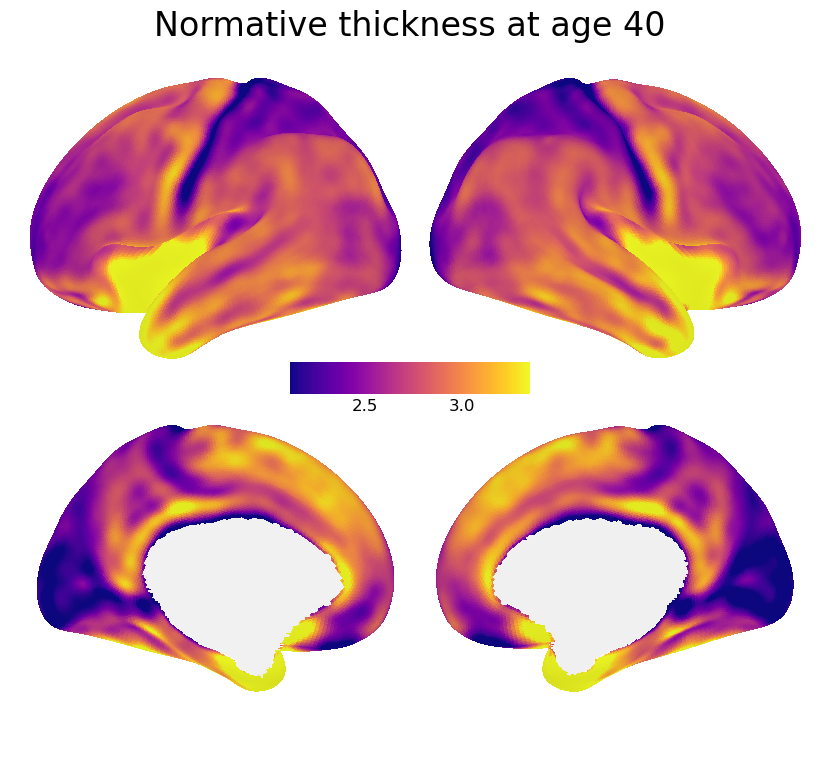

In [191]:
plot_data_on_brain_surface(
    high_resolution_mean_thickness_of_interest,
    title=f"Normative thickness at age {age_of_interest}",
    symmetric_cbar=False, cmap=plt.cm.plasma
)


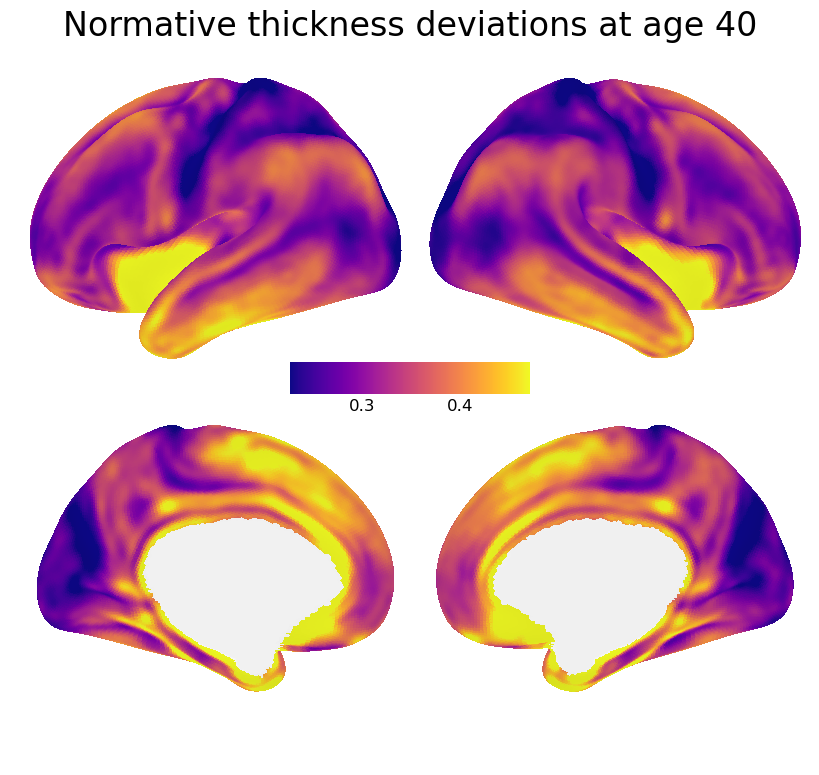

In [206]:
plot_data_on_brain_surface(
    high_resolution_std_thickness_of_interest,
    title=f"Normative thickness deviations at age {age_of_interest}",
    symmetric_cbar=False, cmap=plt.cm.plasma
)


#### Modelling arbitrary queries: individualized high-resolution normative assessment 👤

---

Question: how does a specific individual deviate from the norm?


CPU times: user 13.1 s, sys: 9.41 s, total: 22.5 s
Wall time: 1.53 s


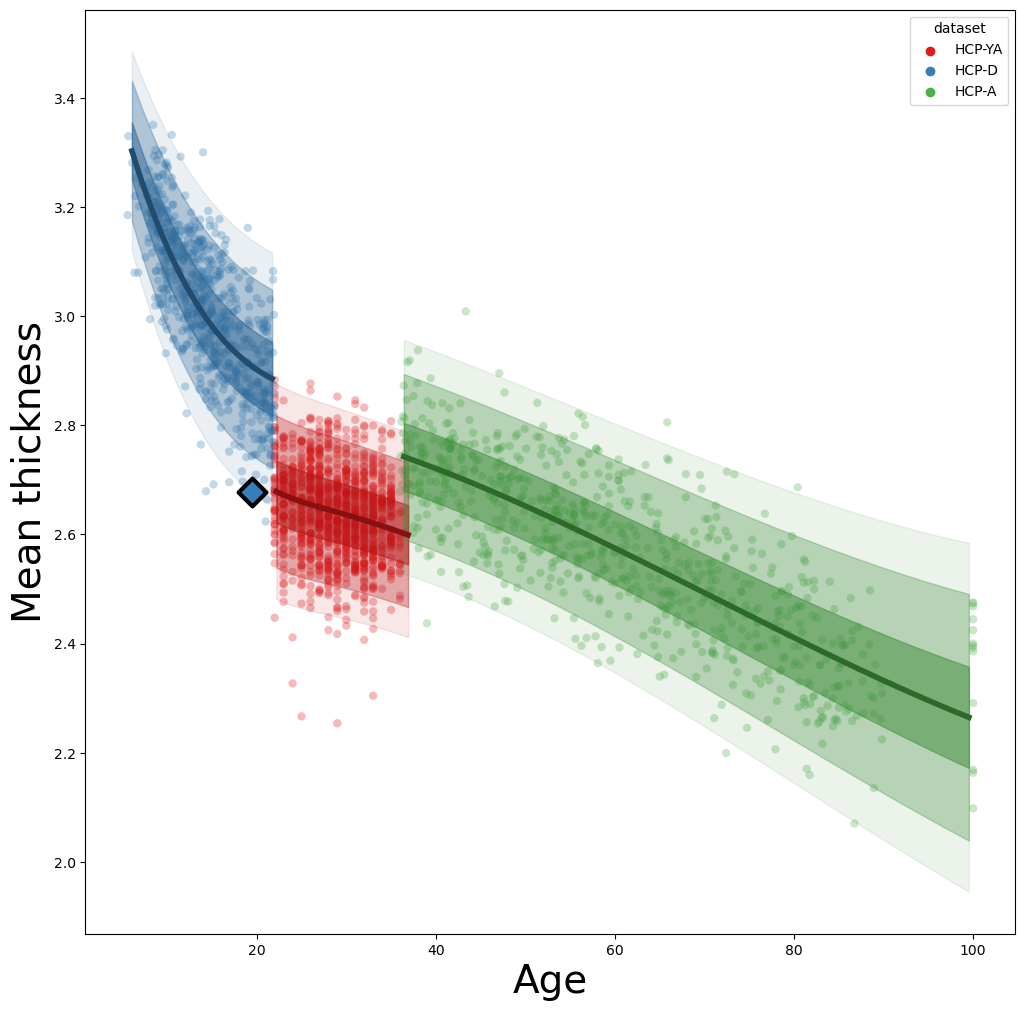

In [235]:
%%time

# First select a random individual

np.random.seed(0)
individual_idx = np.random.choice(np.array(demography_df.index))

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
#     palette=mpl.cm.Set1,
    alpha = 0.3,
#     color=[0.3,0.6,0.9,0.5],
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

for idx in np.unique(site_idxs):
    xi = xr.DataArray(np.linspace(np.min(age), np.max(age), 200), dims=["obs_id"])
    selection = (xi > np.min(age[site_idxs == idx])) & (xi < np.max(age[site_idxs == idx]))
    # post = advi_model_idata.posterior
    
    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    )
    
    kernels_y_ppc_mu_mean = (
        kernel_posterior_means['intercept_sex'].isel(sex=0) +
        kernel_posterior_means['intercept_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])
    y_ppc_mu_mean = np.array(xr.dot(
        xr.DataArray(mean_thickness_vector_encoded.reshape(-1), dims=["kernel"]),
        kernels_y_ppc_mu_mean
    ))

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means['error_sex'].isel(sex=0) +
        kernel_posterior_means['error_site'].isel(site=idx) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["obs_id", "splines"]),
            kernel_posterior_means['w_error_age']
        )
    ) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])
    y_ppc_sigma_mean = np.array(
        [
            np.power(
                np.multiply(
                    mean_thickness_vector_encoded.reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T[i]
                ).dot(
                    correlations
                ).dot(
                    np.multiply(
                        mean_thickness_vector_encoded.reshape(-1,),
                        np.array(kernels_y_ppc_sigma_mean).T[i]
                    ),
                ),
                0.5
            ) for i in range(200)
        ]
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data
    
    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]
    
    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
            )
            # * thickness_std +
            # thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx)[:3])*0.8,
        )
    
    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx)[:3])*0.6,
        lw=4,
    )

ax.scatter(
    [demography_df.iloc[individual_idx]['age']],
    [demography_df.iloc[individual_idx]['thickness']],
    color=np.array(mpl.cm.Set1(demography_df.iloc[individual_idx]['siteCode'])[:3])*1.,
    edgecolors=(0,0,0),
    linewidths=3,
    s=200,
    marker='D'
)


In [243]:
age_of_interest = demography_df.iloc[individual_idx]['age']
sex_of_interest = int(demography_df.iloc[individual_idx]['sex'])
site_of_interest = int(demography_df.iloc[individual_idx]['siteCode'])

xi = xr.DataArray([np.min(age), age_of_interest, np.max(age)], dims=["obs_id"])

prediction_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
)[1]

kernels_y_ppc_mu_mean = (
    kernel_posterior_means['intercept_sex'].isel(sex=sex_of_interest) +
    kernel_posterior_means['intercept_site'].isel(site=site_of_interest) +
    xr.dot(
        xr.DataArray(np.asarray(prediction_B_spline_age), dims=["splines"]),
        kernel_posterior_means['w_age']
    )
) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"]) + xr.DataArray(all_thickness_data_encoded.mean(0), dims=["kernel"])

high_resolution_mean_thickness_of_interest = np.array(kernels_y_ppc_mu_mean).dot(css_kernel_eigenvectors.T)

kernels_y_ppc_sigma_mean = (
    kernel_posterior_means['error_sex'].isel(sex=sex_of_interest) +
    kernel_posterior_means['error_site'].isel(site=site_of_interest) +
    xr.dot(
        xr.DataArray(np.asarray(prediction_B_spline_age), dims=["splines"]),
        kernel_posterior_means['w_error_age']
    )
) * xr.DataArray(all_thickness_data_encoded.std(0), dims=["kernel"])


high_resolution_std_thickness_of_interest = np.array(
    [
        np.power(
            np.multiply(
                css_kernel_eigenvectors[i].reshape(-1,),
                np.array(kernels_y_ppc_sigma_mean).T
            ).dot(
                correlations
            ).dot(
                np.multiply(
                    css_kernel_eigenvectors[i].reshape(-1,),
                    np.array(kernels_y_ppc_sigma_mean).T
                ),
            ),
            0.5
        ) for i in range(css_kernel_eigenvectors.shape[0])
    ]
)


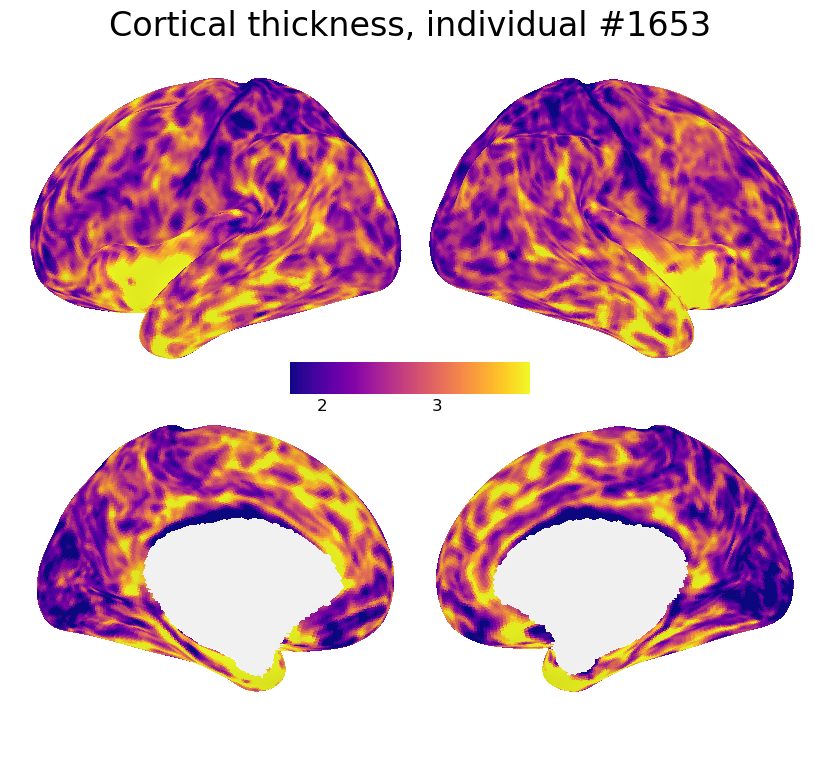

In [248]:
plot_data_on_brain_surface(
    all_thickness_data[individual_idx],
    title=f"Cortical thickness, individual #{individual_idx}",
    symmetric_cbar=False, cmap=plt.cm.plasma
)


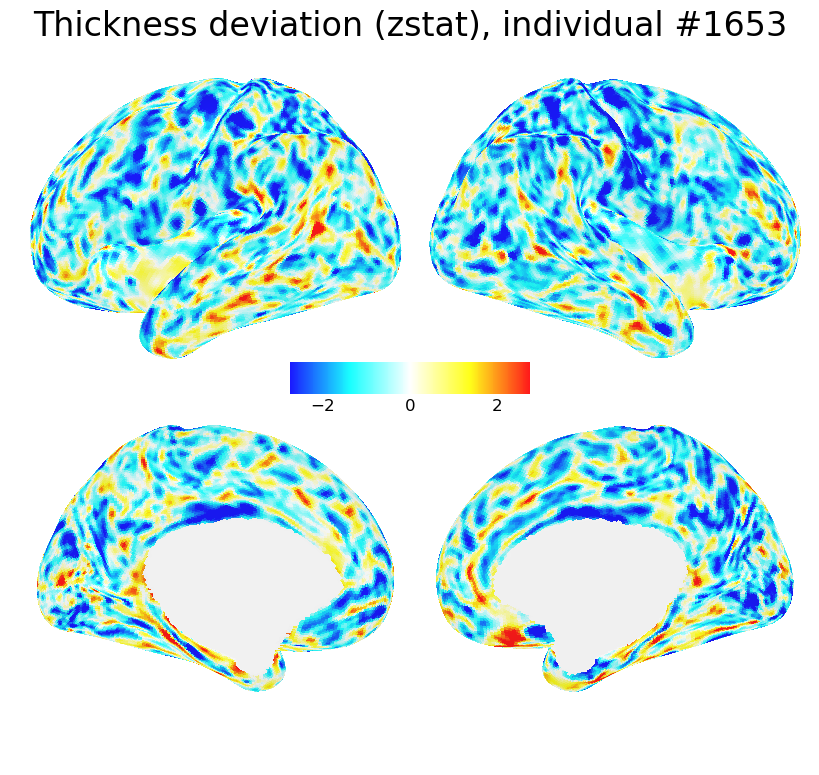

In [250]:
individual_high_resolution_zstat = (all_thickness_data[individual_idx] - high_resolution_mean_thickness_of_interest) / high_resolution_std_thickness_of_interest

plot_data_on_brain_surface(
    individual_high_resolution_zstat,
    title=f"Thickness deviation (zstat), individual #{individual_idx}",
    symmetric_cbar=True,
)


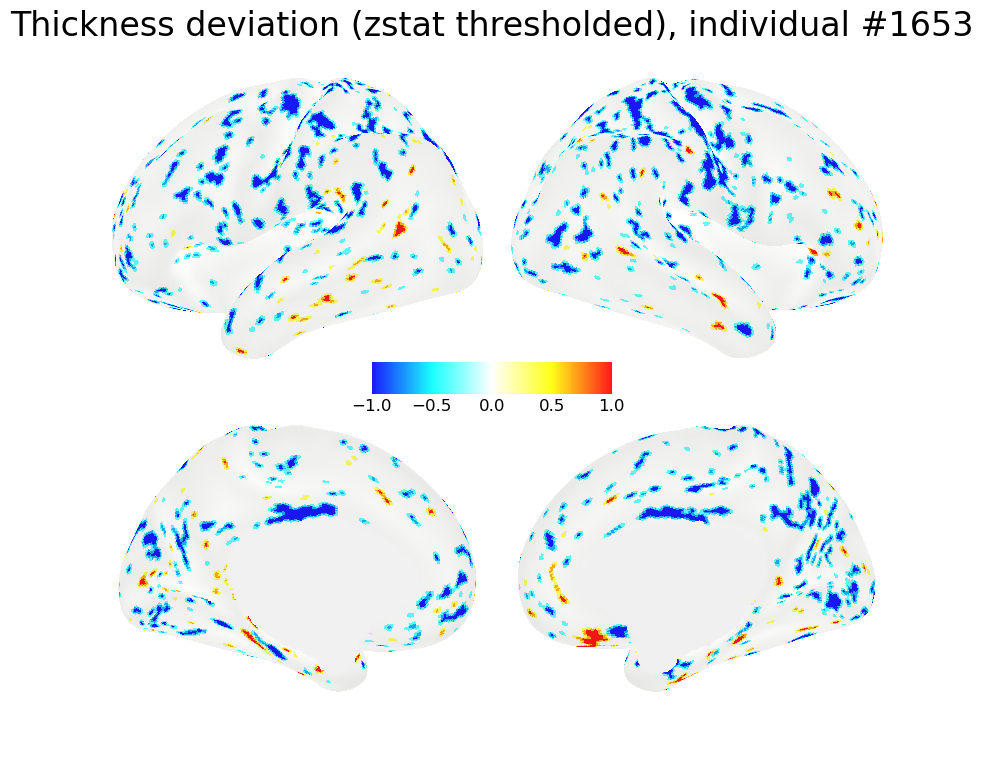

In [253]:
individual_high_resolution_zstat = (all_thickness_data[individual_idx] - high_resolution_mean_thickness_of_interest) / high_resolution_std_thickness_of_interest
z_threshold = 2.3
individual_high_resolution_zstat_thresholded = np.sign(individual_high_resolution_zstat) * (np.abs(individual_high_resolution_zstat) > z_threshold)

plot_data_on_brain_surface(
    individual_high_resolution_zstat_thresholded,
    title=f"Thickness deviation (zstat thresholded), individual #{individual_idx}",
    symmetric_cbar=True,
)
